In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
np.set_printoptions(precision=20)

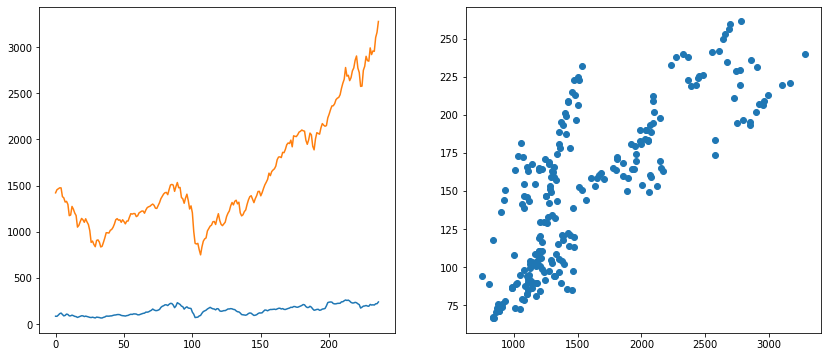

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data_gs = pd.read_csv('GS.csv', parse_dates=['Date'], index_col='Date',date_parser=dateparse)
data_sp500 = pd.read_csv('^GSPC.csv', parse_dates=['Date'], index_col='Date',date_parser=dateparse)

y = ((data_gs['High'] + data_gs['Low']) / 2.).values
x = ((data_sp500['High'] + data_sp500['Low'])/2.).values

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(y)
plt.plot(x)

plt.subplot(1, 2, 2)
plt.scatter(x, y)
plt.show();

In [3]:
class ThreePointMethod():
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.y_mean = self.y.mean()
        self.splits_x, self.splits_y = self.group_splits(self.x, self.y)
        self.median_x, self.median_y = self.group_medians(self.splits_x, self.splits_y)
        self.alpha, self.beta, self.gamma = self.parameters_eval(self.median_x, self.median_y)
    
    def group_splits(self, x, y):
        assert x.shape[0] == y.shape[0]
        n = x.shape[0]
        if n % 3 == 2:
            group_1_3 = n // 3 + 1
            group_2 = n // 3
        elif n % 3 == 1:
            group_1_3 = n // 3
            group_2 = n // 3 + 1
        else:
            group_1_3 = n // 3
            group_2 = n // 3
        group_1_x, group_1_y = x[:group_1_3], y[:group_1_3]
        group_2_x, group_2_y = x[group_1_3:group_1_3 + group_2], y[group_1_3:group_1_3 + group_2]
        group_3_x, group_3_y = x[group_1_3 + group_2:], y[group_1_3 + group_2:]
        return (group_1_x, group_2_x, group_3_x), (group_1_y, group_2_y, group_3_y)
    
    def group_medians(self, splits_x, splits_y):
        med1_x, med2_x, med3_x = np.median(splits_x[0]), np.median(splits_x[1]), np.median(splits_x[2])
        med1_y, med2_y, med3_y = np.median(splits_y[0]), np.median(splits_y[1]), np.median(splits_y[2])
        return (med1_x, med2_x, med3_x), (med1_y, med2_y, med3_y)
    
    def parameters_eval(self, median_x, median_y):
        delta = median_x[1] - median_x[0]
        ln_beta = (1 / delta) * np.log((median_y[2] - median_y[1]) / (median_y[1] - median_y[0]))
        beta = np.exp(ln_beta)
        alpha = (median_y[2] - median_y[1]) / (beta ** median_x[2] - beta ** median_x[1])
        gamma = median_y[0] - alpha * beta ** median_x[0]
        return alpha, beta, gamma
    
    def parameters(self):
        return self.alpha, self.beta, self.gamma
    
    def predict(self, x):
        preds = list()
        for i in x:
            res = self.alpha * self.beta ** i + self.gamma
            preds.append(res)
        return np.array(preds)
    
    def R_squared(self):
        r_suqared = None
        corr_coef = np.corrcoef(self.x, self.y)
        return corr_coef[0][1] ** 2
    
    def F_statistic(self):
        y_hat = self.predict(self.x)
        f_stat = (y.shape[0] - 2) * sum((y_hat - self.y_mean) ** 2) / (sum ((self.y - y_hat) ** 2))
        return f_stat
    

# модифікована експонента $y = \alpha*\beta ^{x} + \gamma $

Alpha: -980.4009479848645  Beta: 0.9977150870291891  Gamma: 162.7037858429989
R_squared: 0.6113160798913284  r: 0.7818670474520131  f_statistic: 271.0632891218642


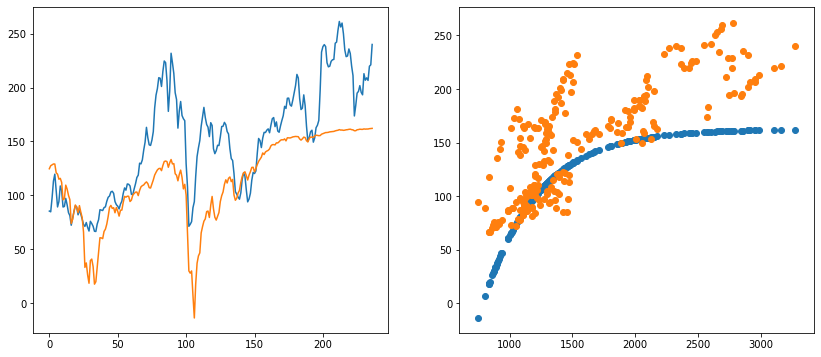

In [4]:
method = ThreePointMethod(x, y)
alpha, beta, gamma = method.parameters()
print(f'Alpha: {alpha}  Beta: {beta}  Gamma: {gamma}')
preds_1 = method.predict(x)
print(f'R_squared: {method.R_squared()}  r: {np.sqrt(method.R_squared())}  f_statistic: {method.F_statistic()}')

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(y)
plt.plot(preds_1)

plt.subplot(1, 2, 2)
plt.scatter(x, preds_1)
plt.scatter(x, y)
plt.show();

# Крива Гомперця $y = e^{\alpha*\beta ^{x} + \gamma} $

Alpha: -124.03674658987205  Beta: 0.9952596207203747  Gamma: 5.038054104232022
R_squared: 0.5588661231844273  r: 0.7475734901562704  f_statistic: 349.6450725383599


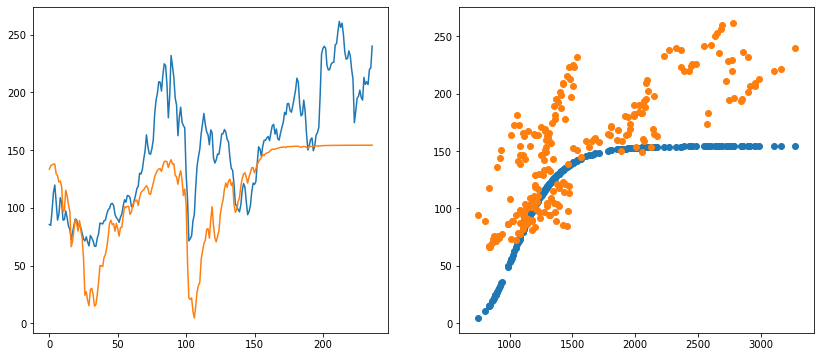

In [5]:
method = ThreePointMethod(x, np.log(y))
alpha, beta, gamma = method.parameters()
print(f'Alpha: {alpha}  Beta: {beta}  Gamma: {gamma}')
preds_2 = method.predict(x)
preds_2 = np.exp(preds_2)
print(f'R_squared: {method.R_squared()}  r: {np.sqrt(method.R_squared())}  f_statistic: {method.F_statistic()}')

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(y)
plt.plot(preds_2)

plt.subplot(1, 2, 2)
plt.scatter(x, preds_2)
plt.scatter(x, y)
plt.show();

# Логістична крива $y = \frac{1}{\alpha*\beta ^{x} + \gamma} $

Alpha: 20.30855870962166  Beta: 0.9927108097503003  Gamma: 0.006535679585465995
R_squared: 0.4868652952220279  r: 0.6977573326178865  f_statistic: 297.997084358088


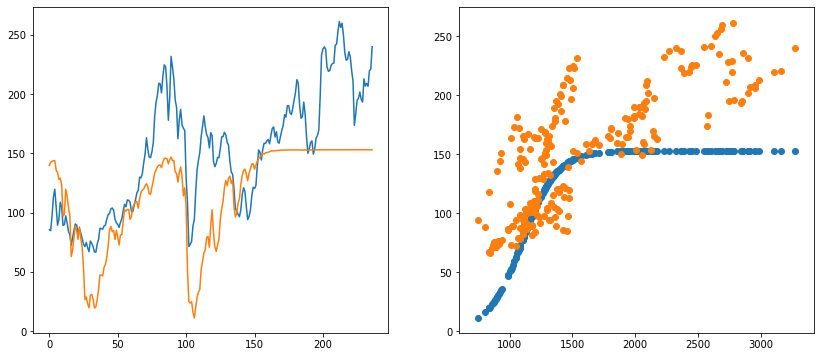

In [6]:
method = ThreePointMethod(x, y ** -1)
alpha, beta, gamma = method.parameters()
print(f'Alpha: {alpha}  Beta: {beta}  Gamma: {gamma}')
preds_3 = method.predict(x)
preds_3 = preds_3 ** -1
print(f'R_squared: {method.R_squared()}  r: {np.sqrt(method.R_squared())}  f_statistic: {method.F_statistic()}')

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(y)
plt.plot(preds_3)

plt.subplot(1, 2, 2)
plt.scatter(x, preds_3)
plt.scatter(x, y)
plt.show();

After we have evaluated all the models we can conclude that the modified exponent performs the best as its R_squared is the highest. 

# Forecast

In [7]:
def confidence_interval(X,y,y_pred,t_crit = 1.96):
    n,e = X.shape[0],y - y_pred
    su_2 = n * np.var(e) / (n-2)

    se = np.sqrt(su_2 * (n + 1 + (X-X.mean())**2 / X.var())/ n)
    delta = se * t_crit
    return y_pred - delta, y_pred + delta

In [8]:
lower, upper = confidence_interval(x, y, preds_1)

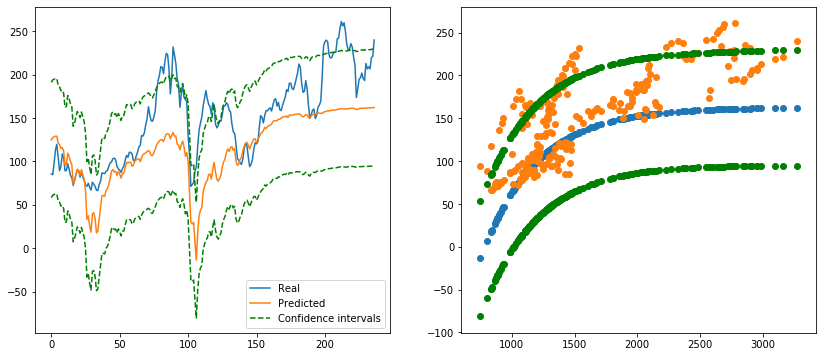

In [9]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(y, label='Real')
plt.plot(preds_1, label='Predicted')
plt.plot(upper, color='green', linestyle = "--", label='Confidence intervals')
plt.plot(lower, color='green', linestyle = "--")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(x, preds_1)
plt.scatter(x, y)
plt.scatter(x, lower, color='green')
plt.scatter(x, upper, color='green')
plt.show();